# Lecture 3: Monte Carlo Simulations

The previous section was concerned with probability distributions and stochastic processes. When introducing stochastic processes, I proposed a "coin game", which is a game where your friend goes on a 1D random walk according to a coin flip. If by the end of the walk they end up to the right of their initial position, they give you 5 dollars and if they end up to the left, you give them 5 dollars. Us being the opportunist finance enthusiats, we wanted to see if this game could be a valid investment by calculating the expected return (mean) and risk (standard deviation). The problem is that we did not have a formula for this stochastic process and therefore could not derive an expression for $\mu$ and $\sigma$. The way we went around this is by simulating the game hundreds of times and getting an estimation for $\mu$ and $\sigma$, in other words, we ran a Monte Carlo simulation. This section will be concerned with the details of how Monte Carlo simulations work and how we can use them in risk management. 

The notebook will be divided into three parts:

 1. Motivation
 2. Inverse Transform Sampling 
 3. Applications

In [1]:
#Importing standard libraries

import numpy as np
from matplotlib import pyplot as plt 
import scipy as sci
import pandas as pd

## Motivation


Stanislaw Ulam, a Polish mathematician and physicist, used to play a lot of solitaire in his free time and out of frustration from losing, he sought out to calculate the probability of winning the game. Naturally, his first instincts were to turn towards combinatorics and analytically derive the winning probability. Unfortunately that proved to be exceptionally hard. He then realized that if he played the games a large number of times and documented whether he won or loss, the problem would reduce down to (number of times won) / (number of times played). This is similar to the methods we used to assess the risk-reward of our coin game. He of course realized that he will need to sample through hundreds, if not thousands of games to get an accurate probability, which is when he then approached John von Neumann to help him simulate the game on a computer. 


This method of estimating unknown parameters by simulating a phenomenon over multiple samples was quickly adopted to industries such as nuclear physics, gambling (in fact where it got its name, the _Monte Carlo Casino_) and to our interest, risk management, where it it typically used to estimate expected returns, volatility, Value at Risk, etc.


Monte Carlo methods are based on the _strong law of large numbers_ which states that a mean of a sample $X_1,\dots, X_n$ (which are iid)

$$S_n = \frac{1}{n}\sum_{i = 1}^n X_i$$

converges at the expectation value $\mathbb{E}(X)$. This means that as $n \rightarrow \infty$, $S_n \rightarrow \mathbb{E}(X)$.

#### Python Implementation

Let us try to randomly generate random numbers that follow the distribution $X \sim N(5,10)$ and analyze how close the sample mean $S_n$ is to the theoretical expected value $\mathbb{E}(X) = 5$ for various number of samples $n$

In [2]:
n_vals = [1,10,100,1000,10000] #the number of samples we will try

for i in n_vals:
    S_i = np.mean([np.random.normal(5,10) for _ in range(i)])
    print("E - S_"+str(i)+": "+str(5 - S_i))

E - S_1: 8.273482788765524
E - S_10: 1.6644659100953931
E - S_100: -0.6209207060097093
E - S_1000: -0.2689719174859633
E - S_10000: -0.05285783847198644


As you can see the difference $E - S_i \rightarrow 0$ as $n \rightarrow \infty$.


## Inverse Transform Sampling

We have used several functions to generate numbers from several distributions eg.`np.random.normal`, `np.random.poisson`, etc. These random number generators are all based on the idea of inverse transform sampling which maps a set of uniformally randomly generated numbers on $[0,1]$ to some probability distribution.

The first step to laying out this method is to define the _pseudo inverse of a CDF_:

 - Let $F: \mathbb{R} \rightarrow [0,1]$ be the commulative distribution function of a random variable $X: \Omega \rightarrow \mathbb{R}$. The pseudo-inverse $F^{\leftarrow}$ is then given by
 
 $$F^{\leftarrow}(u) = \inf\{x \in \mathbb{R}: F(x) \leq u \}$$
 
 where $u \in (0,1)$ and $\inf$ denotes the infinum. In other words it is the smallest number in which the distribution is smaller than some given probability $u$. We use this definition because CDFs are not always invertable but the pseudoinverse, for trivial reasons, is always defined. 
 
 
 
 Inverse Transform Sampling is based on the following theorem:
 
 - Let $X$ be a random variable with CDF $F(x): \mathbb{R} \rightarrow [0,1]$ and pseudoinverse $F^{\leftarrow}: (0,1) \rightarrow \mathbb{R}$. Let $U \sim \mathcal{U}(0,1)$ (i.e uniformly distributed between 0 and 1). Then the following holds:
 
 $$F^{\leftarrow}(U) \sim F$$
 
 In other words, $F^{\leftarrow}(U)$ follows the same distribution as $X$.
 
 We can use this theorem to generate any distribution of random numbers using the following two steps:
 
 1. Generate a random number $u$ from $U \sim \mathcal{U}(0,1)$ (i.e a uniform distribution between, but excluding, 0 and 1).
 2. Calculate $x = F^{\leftarrow}(u)$ of whatever distribution you please. 
 
 
 The following image makes the process more clear: 
 
 <img src="assets/rng.png" width="350">
 
 
 and the following table gives a set of pseudoinverse for common distributions' CDFs
 
 <img src="assets/pseudo.png" width=700>
 
 which are programmed into statistical tools such as `np.random`. Generating an pairs of independent, normally distributed random numbers, one can use the _Box-Muller Transform_ which for $U_1,U_2 \sim \mathcal{U}(0,1)$, is 
 
 $$X = \sqrt{-2\log{U_1}\cos{(2\pi U_2)}}, Y = \sqrt{-2\log{U_1}\sin{(2\pi U_2)}}$$
 
 where $X$ and $Y$ are normally iid. 
 
 
 One can similarly map a sample $X, X_1, \dots, X_n \sim N(0,1)$ to other special distributions using the following transformations:
 
 <img src="assets/bru.png" width=500>
 
 #### Python Implementation
 
 Here we will try to define a function that generates $x$ with distribution $X \sim \mathcal{U}(0,1)$ and then transform it into a set of different distributions.

(array([10097.,  9746., 10073., 10061.,  9919., 10007.,  9865.,  9953.,
        10290.,  9989.]),
 array([2.13386453e-06, 1.00000803e-01, 1.99999472e-01, 2.99998141e-01,
        3.99996810e-01, 4.99995479e-01, 5.99994148e-01, 6.99992817e-01,
        7.99991486e-01, 8.99990155e-01, 9.99988824e-01]),
 <BarContainer object of 10 artists>)

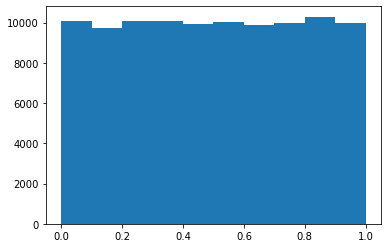

In [3]:
U = lambda: np.random.uniform(0,1) #U(0,1)

u_vals = [U() for i in range(100000)] #100000 random numbers from U(0,1)

plt.hist(u_vals)

(array([7.2953e+04, 1.9598e+04, 5.4000e+03, 1.4830e+03, 4.3000e+02,
        1.0000e+02, 2.3000e+01, 7.0000e+00, 3.0000e+00, 3.0000e+00]),
 array([1.11759475e-06, 1.30576765e-01, 2.61152412e-01, 3.91728059e-01,
        5.22303706e-01, 6.52879353e-01, 7.83455000e-01, 9.14030648e-01,
        1.04460629e+00, 1.17518194e+00, 1.30575759e+00]),
 <BarContainer object of 10 artists>)

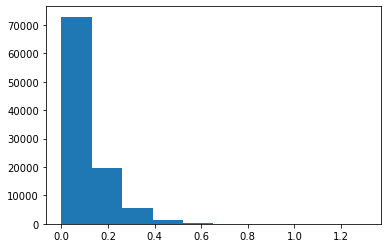

In [4]:
exp = lambda u, lam: -np.log(u)/lam #exponential distribution pseudoinverse CDF

exp_dist = exp(u_vals,10) #mapping uniform dist to exp where lambda = 10

plt.hist(exp_dist)

(array([4.0000e+00, 2.2000e+01, 3.0800e+02, 3.4020e+03, 2.6591e+04,
        5.2922e+04, 1.5110e+04, 1.5070e+03, 1.2400e+02, 1.0000e+01]),
 array([-13.05757376, -10.61164228,  -8.1657108 ,  -5.71977932,
         -3.27384784,  -0.82791636,   1.61801512,   4.0639466 ,
          6.50987808,   8.95580956,  11.40174104]),
 <BarContainer object of 10 artists>)

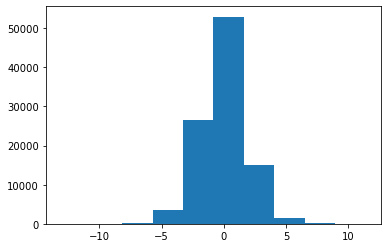

In [5]:
logistic = lambda u: np.log((u)/(1-u)) #logistic dist pseudoinverse CDF

logistic_dist = [logistic(i) for i in u_vals]

plt.hist(logistic_dist)

## Applications


Monte Carlo simulations are a ubiquitous tool across several fields and numerical methods, but here we will present a few relevant applications.

### Calculating Value at Risk (VaR)


The Value at Risk at a confidence level $\alpha \in (0,1)$ is given by the smallest number $I$ for which the probability of a loss $L$ does not exceed $1 - \alpha$, or

$$VaR_{\alpha} = \inf\{I \in \mathbb{R}: P(L > I) \leq 1 - \alpha \} = \inf\{I \in \mathbb{R}: F_L(I) \leq \alpha\}$$


Calculating the VaR could be accomplished with monte carlo simulations using the following steps:

 - Choose a parametric model for the changes in risk factor $X_{t + 1}$
 - Calibrate the model based on historical observed values $X_{t - n + 1},\dots, X_t$
 - Simulate $m$ independent values
 - Calculate the simulated financial losses by plugging in the simulated risk factor changes into the loss function  $\tilde{L}^{(i)}_{t+1} = I_{[t]}(\tilde{X^{(i)}_{t+1}})$ where $i = 1,\dots,m$
 - Calculate the VaR based on the empirical distribution function
 
 
 The following link is an example of this being done in Python: https://aquaq.co.uk/calculating-var-using-monte-carlo-simulation/
 
 
 Note that this could be very computationally expensive especially for large portfolios with complex financial instruments.
 
 ### Option Pricing
 
 
 Certain types of Options (for example, exotic, path-dependent options) are too complex to be modeled analytically and must be done by means of monte carlo simulation. This could be achieved by the following steps:
 
 - Specifying a stochastic process for the movement of the underlying asset and calculating paths of that process (as was done for the coin game)
 - Calculating the payoff of the option at maturity for each simulated path
 - Calculate the arithmetic mean of these payoffs and use as an expected value of the option payoff
 
 ### Monte Carlo Integration
 
 Say we are given the task of evaluating the following integral:
 
 $$I = \int_a^b f(x)dx$$
 
 while there exists multiple deterministic methods that we can use, many of them tend to become less and less efficient as the number of variables increase. As a result, a nondeterministic method that exploits monte carlo simulation is considered. It works in the following way:
 
 Notice that the average value of a function $\langle f(x)\rangle$ between values $a$ and $b$ could be defined as
 
 $$\langle f(x)\rangle = \frac{1}{b-a}\int_a^b f(x)dx$$
 
 by rearranging the equation, one gets
 
 $$\int_a^b f(x)dx = (b - a)\langle f(x)\rangle$$
 
 Remember that the mean $\langle f(x)\rangle$ is simply $\frac{1}{N}\sum_{i} f(x_i)$ as $N \rightarrow \infty$ (where N is the step size). This means that we can approximate the integral as 
 
 $$I \approx (b - a)\frac{1}{N}\sum_{i}f(x_i)$$
 
 where $i$ is obtained according to $U(a,b)$.
 
 
 In other words, to calculate the integral of a function between $a$ and $b$, we
 
  - Calculate $f(x)$ at uniformly distributed random values of $x \in (a,b)$ (repeat the process $N$ times)
  - Sum all of the $f(x_i)$ values up and divide by $N$
  - Multiply the expression by the range $(b - a)$
  
The larger $N$ is, the more accurate the integral is.

#### Python Implementation

Consider the integral 

$$I = \int_0^1 x^2dx$$

which can easily be solved analytically by using the power rule, as done bellow:

$$I = \int_0^1 x^2dx = \frac{x^3}{3}|^1_0 = \frac{1}{3}$$


We will attempt to compute $I$ with monte carlo methods with $N = 10,000$

In [6]:
f = lambda x: x**2 #function

a = 0
b = 1
N = 10000

random_fx = [f(np.random.uniform(a,b)) for _ in range(N)] #getting f(uniformly random values of x between 0 and 1)

I = (b - a)*sum(random_fx)/N #formula above

print('I_MC = ',I)
print('Error = |I - I_MC|',abs(1/3 - I))

I_MC =  0.33199807824510674
Error = |I - I_MC| 0.0013352550882265724


As you can see we get a similar value as the analyical and concequently low error.

##### Now let us try to generalize this into a function:

In [7]:
def mc_integration(f,a,b,N):
    random_fx = [f(np.random.uniform(a,b)) for _ in range(N)]
    return (b - a)*sum(random_fx)/N

##### Let us finally evaluate $I_N$ at various values of N and plot them

In [8]:
N_vals = np.linspace(10,10000,100)

I = 1/3

I_N = [mc_integration(f,0,1,int(i)) for i in N_vals]

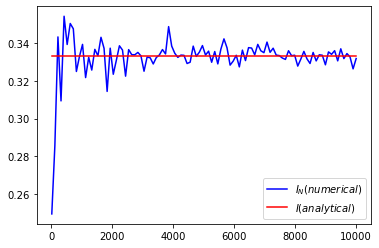

In [9]:
plt.plot(N_vals,I_N,color='blue',label=r'$I_N (numerical)$')
plt.plot(N_vals,[I for _ in N_vals],color='red',label=r'$I (analytical)$')
plt.legend()

As you can see it converges at the analytical value!